In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyomo
import pyomo.opt
import pyomo.environ as pe

from src.parsers import HMParser

In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [128]:
# Auxiliary function to convert numpy arrays to dictionaries

def convert_to_dictionary(a):
    temp_dictionary = {}

    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]

    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]

    return temp_dictionary

# Extract Pyomo values
# https://stackoverflow.com/questions/67491499/how-to-extract-indexed-variable-information-in-pyomo-model-and-build-pandas-data

def ext_pyomo_vals(vals):
    # make a pd.Series from each
    s = pd.Series(vals.extract_values(),
                  index=vals.extract_values().keys())

    # if the series is multi-indexed we need to unstack it...
    if type(s.index[0]) == tuple:    # it is multi-indexed
        s = s.unstack(level=1)
    else:
        # force transition from Series -> df
        s = pd.DataFrame(s)

    return s

In [117]:
# Create model and attribute sets

model = pe.ConcreteModel()

# Set default behaviour
default_behaviour = pe.Constraint.Skip

# Variable iterators
model.t = pe.Set(initialize=np.arange(1, data.generator['p_forecast'].shape[1] + 1),
                 doc='Time periods')

In [118]:
# Create import/export properties

# Sets and Parameters
model.impMax = pe.Param(model.t,
                        initialize=convert_to_dictionary(data.peers['import_contracted_p_max'][0, :]),
                        doc='Maximum import power')
model.expMax = pe.Param(model.t,
                        initialize=convert_to_dictionary(data.peers['export_contracted_p_max'][0, :]),
                        doc='Maximum export power')
model.impCost = pe.Param(model.t,
                         initialize=convert_to_dictionary(data.peers['buy_price'][0, :]),
                         doc='Import cost')
model.expCost = pe.Param(model.t,
                         initialize=convert_to_dictionary(data.peers['sell_price'][0, :]),
                         doc='Export cost')

# Variables
model.imports = pe.Var(model.t, within=pe.NonNegativeReals, initialize=0,
                       doc='Imported power')
model.exports = pe.Var(model.t, within=pe.NonNegativeReals, initialize=0,
                       doc='Exported power')

# Constraints
def _impMaxEq(m, t):
    return m.imports[t] <= m.impMax[t]
model.impMaxEq = pe.Constraint(model.t, rule=_impMaxEq,
                               doc='Maximum import power')

def _expMaxEq(m, t):
    return m.exports[t] <= m.expMax[t]
model.expMaxEq = pe.Constraint(model.t, rule=_expMaxEq,
                               doc='Maximum export power')

In [119]:
# Create generator properties

# Sets and Parameters
model.gen = pe.Set(initialize=np.arange(1, data.generator['p_forecast'].shape[0] + 1),
                   doc='Number of generators')
model.genType = pe.Param(model.gen,
                         initialize=convert_to_dictionary(data.generator['type_generator'].astype(int)),
                         doc='Types of generators')
model.genMin = pe.Param(model.gen,
                        initialize=convert_to_dictionary(data.generator['p_min']),
                        doc='Minimum power generation')
model.genMax = pe.Param(model.gen, model.t,
                        initialize=convert_to_dictionary(data.generator['p_forecast']),
                        doc='Forecasted power generation')
model.genActCost = pe.Param(model.gen, model.t,
                            initialize=convert_to_dictionary(data.generator['cost_parameter_b']),
                            doc='Active power generation cost')
model.genExcCost = pe.Param(model.gen, model.t,
                            initialize=convert_to_dictionary(data.generator['cost_nde']),
                            doc='Excess power generation cost')

# Variables
model.genActPower = pe.Var(model.gen, model.t, within=pe.NonNegativeReals, initialize=0,
                           doc='Active power generation')
model.genExcPower = pe.Var(model.gen, model.t, within=pe.NonNegativeReals, initialize=0,
                           doc='Excess power generation')
model.genXo = pe.Var(model.gen, model.t, within=pe.Binary, initialize=0,
                     doc='Generation on/off')

# Constraints
def _genActMaxEq(m, g, t):
    if m.genType[g] == 1:
        return m.genActPower[g, t] <= m.genMax[g, t]
    elif m.genType[g] == 2:
        return m.genActPower[g, t] + m.genExcPower[g, t] == m.genMax[g, t]
    return default_behaviour
model.genActMaxEq = pe.Constraint(model.gen, model.t, rule=_genActMaxEq,
                                  doc='Maximum active power generation')
def _genActMinEq(m, g, t):
    if m.genType[g] == 1:
        return m.genActPower[g, t] >= m.genMin[g] * m.genXo[g, t]
    return default_behaviour
model.genActMinEq = pe.Constraint(model.gen, model.t, rule=_genActMinEq,
                                  doc='Minimum active power generation')

In [120]:
# Create load properties

# Sets and Parameters
model.loads = pe.Set(initialize=np.arange(1, data.load['p_forecast'].shape[0] + 1),
                    doc='Number of loads')
model.loadMax = pe.Param(model.loads, model.t,
                         initialize=convert_to_dictionary(data.load['p_forecast'] * 5),
                         doc='Forecasted power consumption')
model.loadRedMax = pe.Param(model.loads, model.t,
                            initialize=convert_to_dictionary(data.load['p_forecast'] * 0.5),
                            doc='Maximum power reduction')
model.loadCutMax = pe.Param(model.loads, model.t,
                            initialize=convert_to_dictionary(data.load['p_forecast'] * 0.5),
                            doc='Maximum power cut')
model.loadRedCost = pe.Param(model.loads, model.t,
                             initialize=convert_to_dictionary(data.load['cost_reduce']),
                             doc='Active power reduction cost')
model.loadCutCost = pe.Param(model.loads, model.t,
                             initialize=convert_to_dictionary(data.load['cost_cut']),
                             doc='Active power cut cost')
model.loadENSCost = pe.Param(model.loads, model.t,
                             initialize=convert_to_dictionary(data.load['cost_ens']),
                             doc='Energy not supplied cost')

# Variables
model.loadRedActPower = pe.Var(model.loads, model.t, within=pe.NonNegativeReals, initialize=0,
                               doc='Active power reduction')
model.loadCutActPower = pe.Var(model.loads, model.t, within=pe.NonNegativeReals, initialize=0,
                               doc='Active power cut')
model.loadENS = pe.Var(model.loads, model.t, within=pe.NonNegativeReals, initialize=0,
                       doc='Energy Not Supplied')
model.loadXo = pe.Var(model.loads, model.t, within=pe.Binary, initialize=0,
                      doc='Load on/off')

# Constraints
def _loadRedActEq(m, l, t):
    return m.loadRedActPower[l, t] <= m.loadRedMax[l, t]
model.loadReactEq = pe.Constraint(model.loads, model.t, rule=_loadRedActEq,
                                  doc='Maximum active power reduction')

def _loadCutActEq(m, l, t):
    return m.loadCutActPower[l, t] == m.loadCutMax[l, t] * m.loadXo[l, t]
model.loadCutActEq = pe.Constraint(model.loads, model.t, rule=_loadCutActEq,
                                   doc='Maximum active power cut')

def _loadENSEq(m, l, t):
    return m.loadENS[l, t] + m.loadRedActPower[l, t] + m.loadCutActPower[l, t] <= m.loadMax[l, t]
model.loadENSEq = pe.Constraint(model.loads, model.t, rule=_loadENSEq,
                                doc='Maximum energy not supplied')

In [121]:
# Create storage properties

# Sets and Parameters
model.stor = pe.Set(initialize=np.arange(1, data.storage['p_charge_limit'].shape[0] + 1),
                    doc='Number of storage units')
model.storDchMax = pe.Param(model.stor, model.t,
                            initialize=convert_to_dictionary(data.storage['p_discharge_limit']),
                            doc='Maximum discharging power')
model.storChMax = pe.Param(model.stor, model.t,
                           initialize=convert_to_dictionary(data.storage['p_charge_limit']),
                           doc='Maximum charging power')
model.storMax = pe.Param(model.stor,
                         initialize=convert_to_dictionary(data.storage['energy_capacity']),
                         doc='Maximum energy capacity')
model.storMin = pe.Param(model.stor,
                         initialize=convert_to_dictionary(data.storage['energy_min_percentage']),
                         doc='Minimum energy capacity')
model.storStart = pe.Param(model.stor,
                           initialize=convert_to_dictionary(data.storage['initial_state']),
                           doc='Starting energy capacity')
model.storDchEff = pe.Param(model.stor,
                            initialize=convert_to_dictionary(data.storage['discharge_efficiency']),
                            doc='Discharging efficiency')
model.storChEff = pe.Param(model.stor,
                           initialize=convert_to_dictionary(data.storage['charge_efficiency']),
                           doc='Charging efficiency')
model.storChCost = pe.Param(model.stor, model.t,
                            initialize=convert_to_dictionary(data.storage['charge_price']),
                            doc='Charging cost')
model.storDchCost = pe.Param(model.stor, model.t,
                             initialize=convert_to_dictionary(data.storage['discharge_price']),
                             doc='Discharging cost')

# Variables
model.storState = pe.Var(model.stor, model.t, within=pe.NonNegativeReals, initialize=0,
                         doc='State of charge')
model.storCharge = pe.Var(model.stor, model.t, within=pe.NonNegativeReals, initialize=0,
                          doc='Charging power')
model.storDischarge = pe.Var(model.stor, model.t, within=pe.NonNegativeReals, initialize=0,
                             doc='Discharging power')
model.storRelax = pe.Var(model.stor, model.t, within=pe.NonNegativeReals, initialize=0,
                         doc='Relaxation variable')
model.storChXo = pe.Var(model.stor, model.t, within=pe.Binary, initialize=0,
                        doc='Charging on/off')
model.storDchXo = pe.Var(model.stor, model.t, within=pe.Binary, initialize=0,
                         doc='Discharging on/off')

# Constraints
def _storDchRateEq(m, s, t):
    return m.storDischarge[s, t] <= m.storDchMax[s, t] * m.storDchXo[s, t]
model.storDchRateEq = pe.Constraint(model.stor, model.t, rule=_storDchRateEq,
                                    doc='Maximum discharging rate')

def _storChRateEq(m, s, t):
    return m.storCharge[s, t] <= m.storChMax[s, t] * m.storChXo[s, t]
model.storChRateEq = pe.Constraint(model.stor, model.t, rule=_storChRateEq,
                                   doc='Maximum charging rate')

def _storMaxEq(m, s, t):
    return m.storState[s, t] <= m.storMax[s]
model.storMaxEq = pe.Constraint(model.stor, model.t, rule=_storMaxEq,
                                doc='Maximum energy capacity')

def _storRelaxEq(m, s, t):
    return m.storState[s, t] >= m.storMax[s] * m.storMin[s]  - m.storRelax[s, t]
model.storRelaxEq = pe.Constraint(model.stor, model.t, rule=_storRelaxEq,
                                  doc='Relaxation variable')

def _storBalanceEq(m, s, t):
    if t == 1:
        return m.storState[s, t] == m.storMax[s] * m.storStart[s] + m.storCharge[s, t] * m.storChEff[s] - m.storDischarge[s, t] / m.storDchEff[s]
    elif t > 1:
        return m.storState[s, t] == m.storState[s, t - 1] + m.storCharge[s, t] * m.storChEff[s] - m.storDischarge[s, t] / m.storDchEff[s]
    return default_behaviour
model.storBalanceEq = pe.Constraint(model.stor, model.t, rule=_storBalanceEq,
                                    doc='Energy balance')

def _storChDchEq(m, s, t):
    return m.storChXo[s, t] + m.storDchXo[s, t] <= 1
model.storChDchEq = pe.Constraint(model.stor, model.t, rule=_storChDchEq,
                                  doc='Charging and discharging are mutually exclusive')

In [122]:
# Create V2G properties

# Sets and Parameters
model.v2g = pe.Set(initialize=np.arange(1, data.vehicle['p_charge_max'].shape[0] + 1),
                   doc='Number of EVs')
model.v2gDchMax = pe.Param(model.v2g, model.t,
                           initialize=convert_to_dictionary((data.vehicle['p_discharge_max'] *
                                                             data.vehicle['schedule'].transpose()).transpose()),
                           doc='Maximum scheduled discharging power')
model.v2gChMax = pe.Param(model.v2g, model.t,
                          initialize=convert_to_dictionary((data.vehicle['p_charge_max'] *
                                                            data.vehicle['schedule'].transpose()).transpose()),
                          doc='Maximum scheduled charging power')
model.v2gDchEff = pe.Param(model.v2g,
                           initialize=convert_to_dictionary(data.vehicle['discharge_efficiency']),
                           doc='Discharging efficiency')
model.v2gChEff = pe.Param(model.v2g,
                          initialize=convert_to_dictionary(data.vehicle['charge_efficiency']),
                          doc='Charging efficiency')
model.v2gMax = pe.Param(model.v2g,
                        initialize=convert_to_dictionary(data.vehicle['e_capacity_max']),
                        doc='Maximum energy capacity')
model.v2gMin = pe.Param(model.v2g,
                        initialize=convert_to_dictionary(data.vehicle['e_capacity_max'] * data.vehicle['min_technical_soc']),
                        doc='Minimum energy capacity')
model.v2gSchedule = pe.Param(model.v2g, model.t,
                             initialize=convert_to_dictionary(data.vehicle['schedule']),
                             doc='Vehicle schedule')
model.v2gScheduleArrivalSOC = pe.Param(model.v2g, model.t,
                                       initialize=convert_to_dictionary(data.vehicle['schedule_arrival_soc']),
                                       doc='Vehicle schedule arrival SOC')
model.v2gScheduleDepartureSOC = pe.Param(model.v2g, model.t,
                                         initialize=convert_to_dictionary(data.vehicle['schedule_departure_soc']),
                                         doc='Vehicle schedule required')
model.v2gChCost = pe.Param(model.v2g, model.t,
                           initialize=convert_to_dictionary((np.ones(data.vehicle['schedule'].shape).transpose() *\
                                                             data.vehicle['charge_price'][:, 0]).transpose()),
                           doc='Charging cost')
model.v2gDchCost = pe.Param(model.v2g, model.t,
                            initialize=convert_to_dictionary((np.ones(data.vehicle['schedule'].shape).transpose() *\
                                                              data.vehicle['discharge_price'][:, 0]).transpose()),
                            doc='Discharging cost')

# Variables
model.v2gCharge = pe.Var(model.v2g, model.t, within=pe.NonNegativeReals, initialize=0,
                         doc='Charging power')
model.v2gDischarge = pe.Var(model.v2g, model.t, within=pe.NonNegativeReals, initialize=0,
                            doc='Discharging power')
model.v2gState = pe.Var(model.v2g, model.t, within=pe.NonNegativeReals, initialize=0,
                        doc='State of charge')
model.v2gRelax = pe.Var(model.v2g, model.t, within=pe.NonNegativeReals, initialize=0,
                        doc='Relaxation variable')
model.v2gChXo = pe.Var(model.v2g, model.t, within=pe.Binary, initialize=0,
                       doc='Charging on/off')
model.v2gDchXo = pe.Var(model.v2g, model.t, within=pe.Binary, initialize=0,
                        doc='Discharging on/off')

# Constraints
def _v2gDchRateEq(m, v, t):
    return m.v2gDischarge[v, t] <= m.v2gDchMax[v, t] * m.v2gDchXo[v, t]
model.v2gDchRateEq = pe.Constraint(model.v2g, model.t, rule=_v2gDchRateEq,
                                   doc='Maximum discharging rate')

def _v2gChRateEq(m, v, t):
    return m.v2gCharge[v, t] <= m.v2gChMax[v, t] * m.v2gChXo[v, t]
model.v2gChRateEq = pe.Constraint(model.v2g, model.t, rule=_v2gChRateEq,
                                  doc='Maximum charging rate')

def _v2gMaxEq(m, v, t):
    return m.v2gState[v, t] <= m.v2gMax[v]
model.v2gMaxEq = pe.Constraint(model.v2g, model.t, rule=_v2gMaxEq,
                               doc='Maximum energy capacity')

def _v2gRelaxEq(m, v, t):
    if m.v2gSchedule[v, t] == 1:
        return m.v2gState[v, t] >= m.v2gMin[v] - m.v2gRelax[v, t]
    elif t < m.t.last():
        if (m.v2gSchedule[v, t] == 1) & (m.v2gSchedule[v, t + 1] == 0) & (m.v2gScheduleDepartureSOC[v, t] == 0):
            return m.v2gState[v, t] >= m.v2gMax[v] - m.v2gRelax[v, t]
    elif (m.v2gSchedule[v, t] == 1) & (m.v2gScheduleDepartureSOC[v, t] == 0) & (m.t == m.t.last()):
        return m.v2gState[v, t] >= m.v2gMax[v] - m.v2gRelax[v, t]
    return default_behaviour
model.v2gRelaxEq = pe.Constraint(model.v2g, model.t, rule=_v2gRelaxEq,
                                 doc='Relaxation variable')

def _v2gStateEq(m, v, t):
    if m.v2gSchedule[v, t] == 0: # If vehicle is not scheduled
        return m.v2gState[v, t] == 0
    elif (m.v2gSchedule[v, t] == 1) & (t == 1): # If vehicle is scheduled and it is the first time step
        return m.v2gState[v, t] == m.v2gState[v, t] + m.v2gCharge[v, t] * m.v2gChEff[v] - m.v2gDischarge[v, t] / m.v2gDchEff[v]
    elif t > 1: # If not the first time step
        if (m.v2gSchedule[v, t - 1] == 1) & (m.v2gSchedule[v, t] == 1): # If was and is currently connected
            return m.v2gState[v, t] == m.v2gState[v, t - 1] + m.v2gCharge[v, t] * m.v2gChEff[v] - m.v2gDischarge[v, t] / m.v2gDchEff[v]
        elif (m.v2gSchedule[v, t - 1] == 0) & (m.v2gSchedule[v, t] == 1): # If became connected
            return m.v2gState[v, t] == m.v2gScheduleArrivalSOC[v, t] + m.v2gCharge[v, t] * m.v2gChEff[v] - m.v2gDischarge[v, t] / m.v2gDchEff[v]
    return default_behaviour
model.v2gStateEq = pe.Constraint(model.v2g, model.t, rule=_v2gStateEq,
                                 doc='State of charge')

def _v2gChDchEq(m, v, t):
    return m.v2gCharge[v, t] + m.v2gDischarge[v, t] <= 1
model.v2gChDchEq = pe.Constraint(model.v2g, model.t, rule=_v2gChDchEq,
                                 doc='Charging and discharging cannot occur simultaneously')

In [123]:
# Create Charging Station properties

# Sets and Parameters
model.cs = pe.Set(initialize=np.arange(1, data.charging_station['p_charge_limit'].shape[0] + 1),
                  doc='Number of charging stations')
model.csMax = pe.Param(model.cs, initialize=convert_to_dictionary(data.charging_station['p_charge_max']),
                       doc='Maximum charging power')
model.csMin = pe.Param(model.cs, initialize=convert_to_dictionary(data.charging_station['p_discharge_max']),
                       doc='Maximum discharging power')
model.csChEff = pe.Param(model.cs, initialize=convert_to_dictionary(
    data.charging_station['charge_efficiency'] * 0.01),
                         doc='Charging efficiency')
model.csDchEff = pe.Param(model.cs, initialize=convert_to_dictionary(
    data.charging_station['discharge_efficiency'] * 0.01),
                          doc='Discharging efficiency')
model.csSchedule = pe.Param(model.cs, model.v2g, model.t, initialize=convert_to_dictionary(
    data.vehicle['schedule_cs_usage']),
                            doc='Charging station schedule')

# Variables
model.csCharge = pe.Var(model.cs, model.t, within=pe.NonNegativeReals, initialize=0,
                        doc='Charging power')
model.csNetCharge = pe.Var(model.cs, model.t, within=pe.NonNegativeReals, initialize=0,
                           doc='Net charging power')

# Constraints
def _csMaxEq(m, c, t):
    return m.csCharge[c, t] <= m.csMax[c]
model.csMaxEq = pe.Constraint(model.cs, model.t, rule=_csMaxEq,
                              doc='Maximum charging power')

def _csMinEq(m, c, t):
    return m.csCharge[c, t] >= -m.csMin[c]
model.csMinEq = pe.Constraint(model.cs, model.t, rule=_csMinEq,
                              doc='Maximum discharging power')

def _csPowerEq(m, c, t):
    temp_val = []
    for v in np.arange(1, m.v2g.last() + 1):
        if m.csSchedule[c, v, t] > 0:
            temp_val.append(m.v2gCharge[v, t] - m.v2gDischarge[v, t])
    return m.csCharge[c, t] == sum(temp_val)
model.csPowerEq = pe.Constraint(model.cs, model.t, rule=_csPowerEq,
                                doc='Charging station power')

def _csNetChargeEq(m, c, t):
    temp_val = []
    for v in np.arange(1, m.v2g.last() + 1):
        if m.csSchedule[c, v, t] > 0:
            temp_val.append(m.v2gCharge[v, t] * m.v2gChEff[v] - m.v2gDischarge[v, t] / m.v2gDchEff[v])
    return m.csNetCharge[c, t] == sum(temp_val)
model.csNetChargeEq = pe.Constraint(model.cs, model.t, rule=_csNetChargeEq,
                                    doc='Net charging power')

In [124]:
# Balance equation

def _balanceEq(m, t):
    temp_gens = sum([m.genActPower[g, t] - m.genExcPower[g, t]
                     for g in np.arange(1, m.gen.last() + 1)])

    temp_loads = sum([m.loadMax[l, t] - m.loadRedActPower[l, t] - m.loadCutActPower[l, t] - m.loadENS[l, t]
                      for l in np.arange(1, m.loads.last() + 1)])

    temp_stor = sum([m.storCharge[s, t] - m.storDischarge[s, t]
                     for s in np.arange(1, m.stor.last() + 1)])

    temp_v2g = sum([m.v2gCharge[v, t] - m.v2gDischarge[v, t]
                    for v in np.arange(1, m.v2g.last() + 1)])

    temp_cs = sum(m.csNetCharge[:, t])

    return temp_gens - temp_loads - temp_stor - temp_v2g - temp_cs + m.imports[t] - m.exports[t] == 0
model.balanceEq = pe.Constraint(model.t, rule=_balanceEq,
                                doc='Balance equation')

In [125]:
# Objective Function

def _objFn(m):

    temp_gens = sum([m.genActPower[g, t] * m.genActCost[g, t] + m.genExcPower[g, t] * m.genExcCost[g, t]
                     for t in np.arange(1, m.t.last() + 1) for g in np.arange(1, m.gen.last() + 1)])

    temp_loads = sum([m.loadRedActPower[l, t] * m.loadRedCost[l, t] +\
                      m.loadCutActPower[l, t] * m.loadCutCost[l, t] +\
                      m.loadENS[l, t] * m.loadENSCost[l, t]
                      for t in np.arange(1, m.t.last() + 1) for l in np.arange(1, m.loads.last() + 1)])

    temp_stor = sum([m.storDischarge[s, t] * m.storDchCost[s, t] - \
                     m.storCharge[s, t] * m.storChCost[s, t]
                     for t in np.arange(1, m.t.last() + 1) for s in np.arange(1, m.stor.last() + 1)])

    temp_v2g = sum([m.v2gDischarge[v, t] * m.v2gDchCost[v, t] - \
                    m.v2gCharge[v, t] * m.v2gChCost[v, t] +\
                    m.v2gRelax[v, t] * 200
                    for t in np.arange(1, m.t.last() + 1) for v in np.arange(1, m.v2g.last() + 1)])

    temp_rest = sum([m.imports[t] * m.impCost[t] - m.exports[t] * m.expCost[t]
                     for t in np.arange(1, m.t.last() + 1)])

    return temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest
model.objFn = pe.Objective(rule=_objFn, sense=pe.minimize,
                           doc='Objective function')

In [127]:
# Solve the model

# Write the model to a file
model.write('res_community.lp', io_options={'symbolic_solver_labels': True})

# Solve the model
solver = pe.SolverFactory('scip', executable='C:/Program Files/SCIPOptSuite 8.0.3/bin/scip.exe')
solver.options['LogFile'] = 'res_community.log'

results = solver.solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: 133.444898697226
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 2110
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: optimal solution found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.0
  Gap: 0.0
  Primal bound: 133.444898697226
  Dual bound: 133.444898697226
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

In [131]:
# Result extraction

# Generation
result_genActPower = ext_pyomo_vals(model.genActPower)
result_genExcActPower = ext_pyomo_vals(model.genExcPower)

# Imports/Exports
result_pimp = ext_pyomo_vals(model.imports)
result_pexp = ext_pyomo_vals(model.exports)

# Loads
result_loadRedActPower = ext_pyomo_vals(model.loadRedActPower)
result_loadCutActPower = ext_pyomo_vals(model.loadCutActPower)
result_loadENS = ext_pyomo_vals(model.loadENS)

# Storage
result_storDchActPower = ext_pyomo_vals(model.storDischarge)
result_storChActPower = ext_pyomo_vals(model.storCharge)
result_storEnerState = ext_pyomo_vals(model.storState)

# V2G
result_v2gDchActPower = ext_pyomo_vals(model.v2gDischarge)
result_v2gChActPower = ext_pyomo_vals(model.v2gCharge)
result_v2gEnerState = ext_pyomo_vals(model.v2gState)

# Charging Stations
result_csActPower = ext_pyomo_vals(model.csCharge)
result_csActPowerNet = ext_pyomo_vals(model.csNetCharge)

# Booleans
result_genXo = ext_pyomo_vals(model.genXo)
result_loadXo = ext_pyomo_vals(model.loadXo)
result_storDchXo = ext_pyomo_vals(model.storDchXo)
result_storChXo = ext_pyomo_vals(model.storChXo)
result_v2gDchXo = ext_pyomo_vals(model.v2gDchXo)
result_v2gChXo = ext_pyomo_vals(model.v2gChXo)

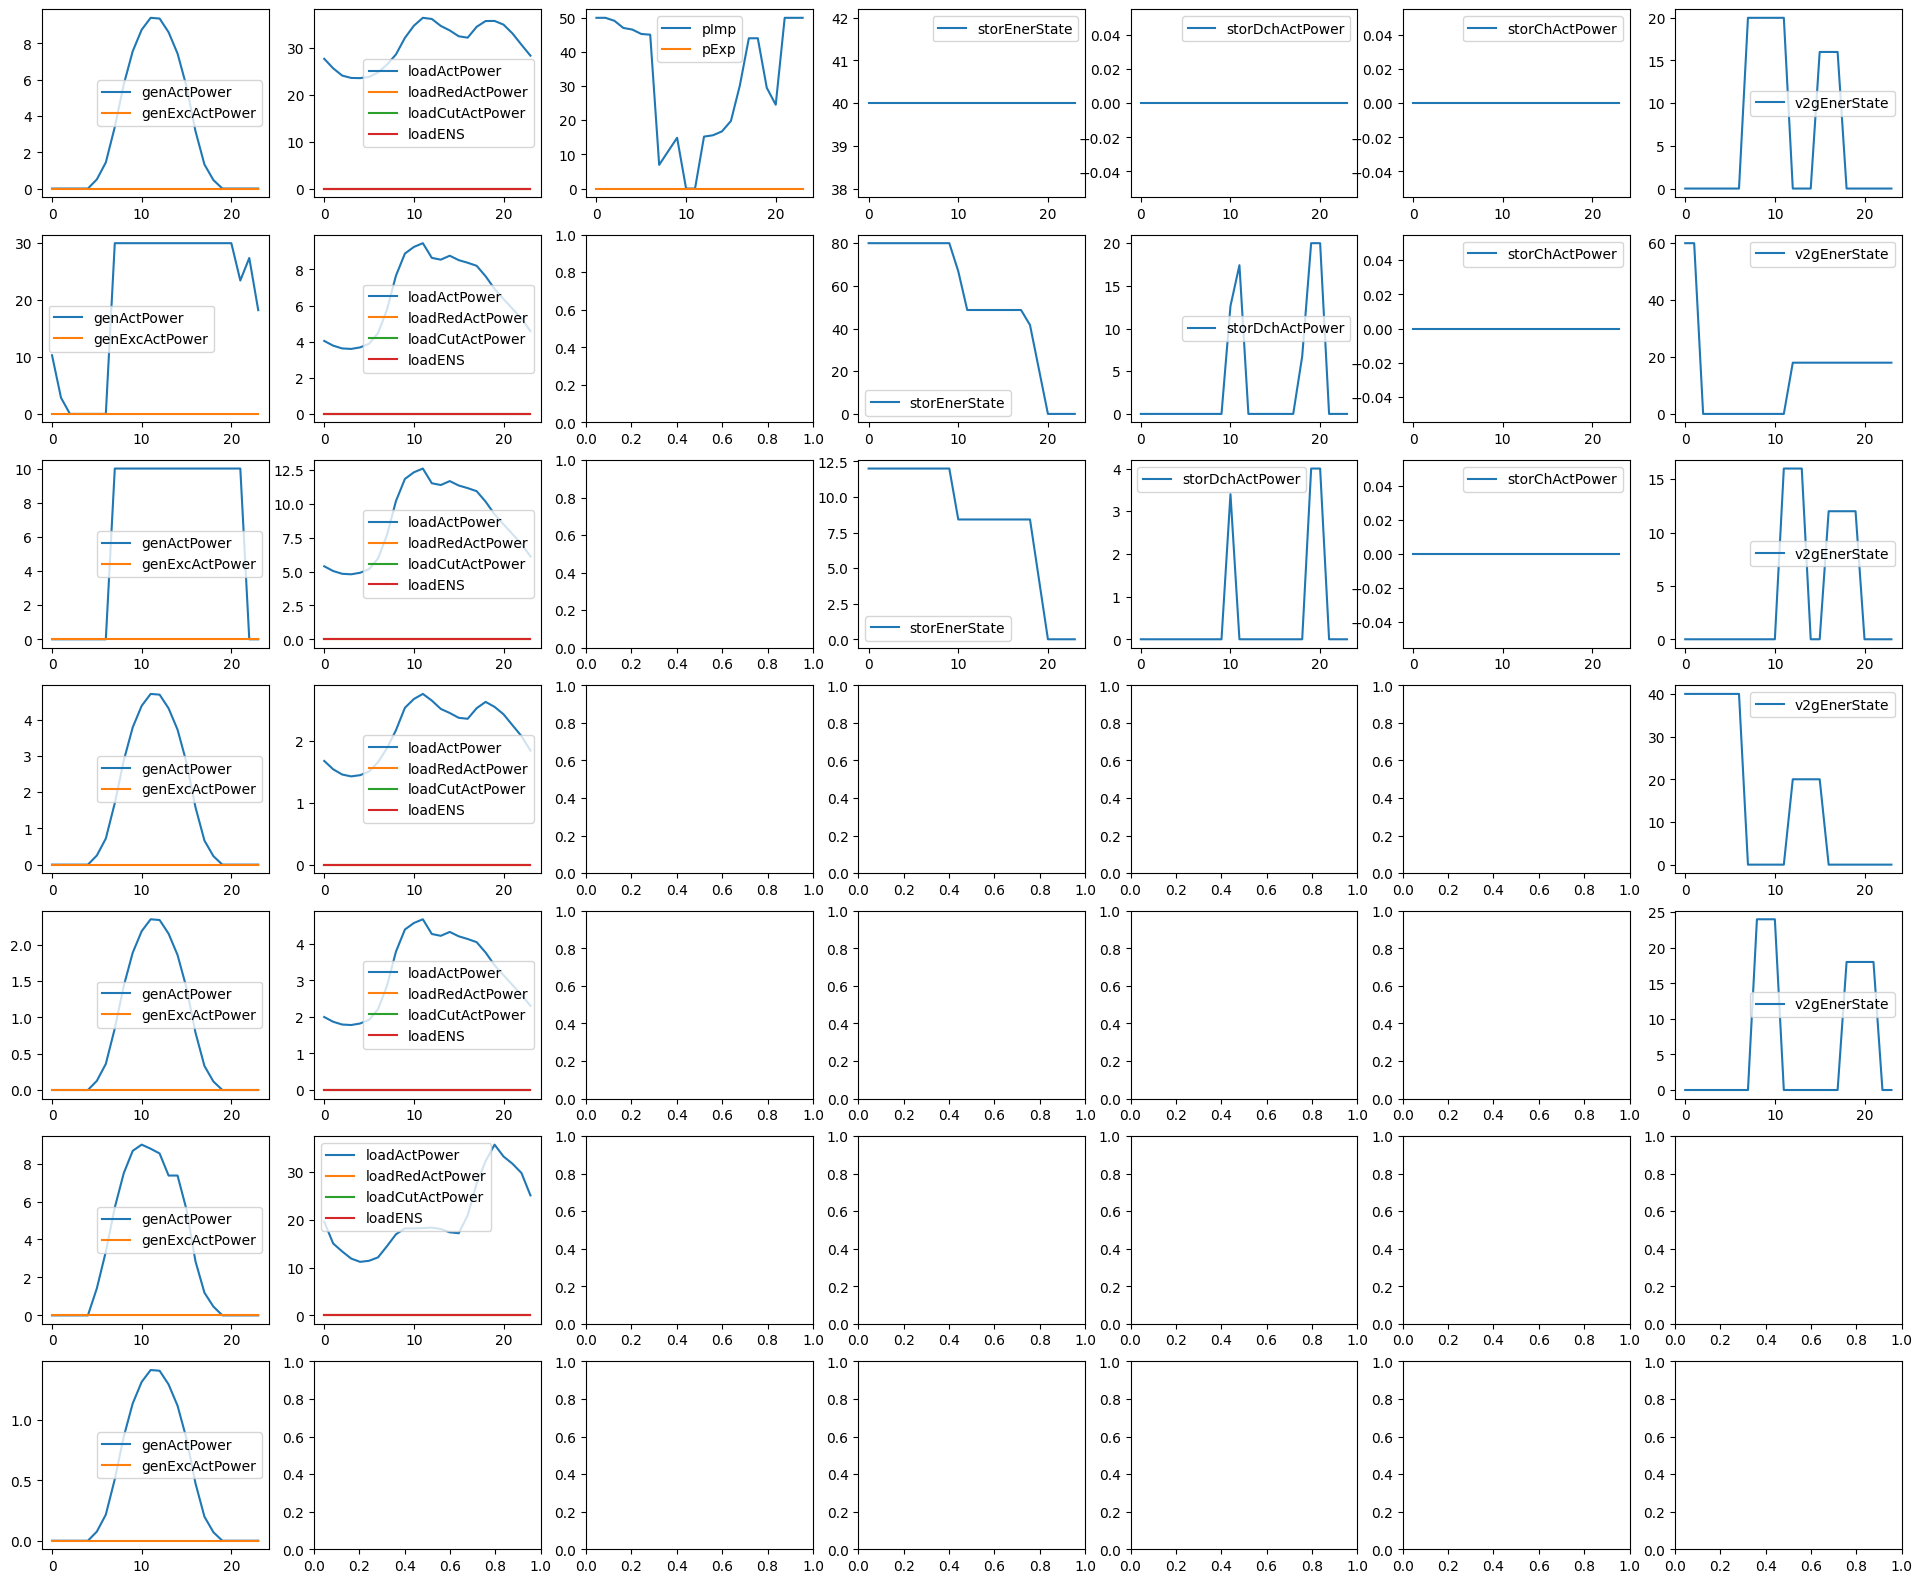

In [133]:
# Plot results

fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(24, 20))

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i])
    axs[i, 0].plot(result_genExcActPower.values[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])

for i in np.arange(6):
    # Loads
    axs[i, 1].plot((data.load['p_forecast'][:, :]*5)[i, :])
    axs[i, 1].plot(result_loadRedActPower.values[i])
    axs[i, 1].plot(result_loadCutActPower.values[i])
    axs[i, 1].plot(result_loadENS.values[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(result_pimp.values)
axs[0, 2].plot(result_pexp.values)
axs[0, 2].legend(['pImp', 'pExp'])


for i in range(3):
    axs[i, 3].plot(result_storEnerState.values[i])
    axs[i, 3].legend(['storEnerState'])

for i in range(3):
    axs[i, 4].plot(result_storDchActPower.values[i])
    axs[i, 4].legend(['storDchActPower'])

for i in range(3):
    axs[i, 5].plot(result_storChActPower.values[i])
    axs[i, 5].legend(['storChActPower'])

for i in range(5):
    axs[i, 6].plot(result_v2gEnerState.values[i])
    axs[i, 6].legend(['v2gEnerState'])


plt.show()